## DEVELOP A FACE RECOGNITION SYSTEM USING FACENET IN KERAS

This notebook contains 5 parts, they are:<br>
<ol>
    <li>Face Recognition</li>
    <li>FaceNet Model</li>
    <li>How to load FaceNet model in Keras</li>
    <li>How to detect face for face recognition</li>
    <li>How to develop a face recognition system</li>
</ol>

## Face Recognition

Face recognition is the general task of identifying and verifying people from photographs of their face.<br>
The 2011 book on face recognition titled “Handbook of Face Recognition” describes two main modes for face recognition, as:<br>
<ul>
    <li><b>Face Verification</b>: A one-to-one mapping of a given face against a known identity (e.g. is this the person?).</li>
    <li><b>Face Identification</b>: A one-to-many mapping for a given face against a database of known faces (e.g. who is this person?).</li>

## FaceNet Model

FaceNet is a face recognition system that was described by Florian Schroff, et al. at Google in their 2015 paper titled <a href= https://arxiv.org/abs/1503.03832>FaceNet: A Unified Embedding for Face Recognition and Clustering.</a><br>
It is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a face embedding.<br>

## How to Load a FaceNet Model in Keras

There are a number of projects that provide tools to train FaceNet-based models and make use of pre-trained models. <br>
A notable example is Keras FaceNet by Hiroki Taniai. His project provides a script for converting the Inception ResNet v1 model from TensorFlow to Keras. He also provides a pre-trained Keras model ready for use.<br>
We will use the pre-trained Keras FaceNet model provided by Hiroki Taniai in this tutorial. It was trained on MS-Celeb-1M dataset and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.<br>
The model can be downloaded from here:<br>
<ul>
    <li><a href = https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn>Keras FaceNet Pre-Trained Model (88 megabytes)</a></li>
</ul>
We can load the model directly in Keras using the load_model() function; for example:<br>

In [7]:
# example of loading the keras facenet model
from tensorflow.keras.models import load_model
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/Identity:0' shape=(None, 128) dtype=float32>]


## How to Detect Faces for Face Recognition

In this tutorial, we will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection, e.g. finding and extracting faces from photos. This is a state-of-the-art deep learning model for face detection, described in the 2016 paper titled <a href = https://arxiv.org/abs/1604.02878>Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks</a><br>
We will use the implementation provided by Iván de Paz Centeno in the ipazc/mtcnn project. This can also be installed via pip as follows:<br>

In [8]:
!pip install mtcnn

The first step is to load an image as a NumPy array, which we can achieve using the PIL library and the open() function. We will also convert the image to RGB, just in case the image has an alpha channel or is black and white.<br>
<code>
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
</code>
Next, we can create an MTCNN face detector class and use it to detect all faces in the loaded photograph.<br>
<code>
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
</code>
If we assume there is only one face in the photo for our experiments, we can determine the pixel coordinates of the bounding box as follows. Sometimes the library will return a negative pixel index, and I think this is a bug. We can fix this by taking the absolute value of the coordinates.<br>
<code>
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
</code>
Tying all of this together, the function extract_face() will load a photograph from the loaded filename and return the extracted face. It assumes that the photo contains one face and will return the first face detected.<br>

In [ ]:
# function for face detection with mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load the photo and extract the face
pixels = extract_face('...')

We can use this function to extract faces as needed in the next section that can be provided as input to the FaceNet model.

## How to Develop a Face Classification System

The model will be trained and tested using the ‘5 Celebrity Faces Dataset‘ that contains many photographs of five different celebrities.

We will use an MTCNN model for face detection, the FaceNet model will be used to create a face embedding for each detected face, then we will develop a Linear Support Vector Machine (SVM) classifier model to predict the identity of a given face.

### 5 Celebrity Faces Dataset
The 5 Celebrity Faces Dataset is a small dataset that contains photographs of celebrities.

It includes photos of: Ben Affleck, Elton John, Jerry Seinfeld, Madonna, and Mindy Kaling.

<a href = https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset>5 Celebrity Faces Dataset, Kaggle</a>


In [ ]:
!unzip 5-celebrity-faces-dataset.zip

### Detect Faces
The first step is to detect the face in each photograph and reduce the dataset to a series of faces only.<br>

Let’s test out our face detector function defined in the previous section, specifically extract_face().<br>

Looking in the ‘5-celebrity-faces-dataset/train/ben_afflek/‘ directory, we can see that there are 14 photographs of Ben Affleck in the training dataset. We can detect the face in each photograph, and create a plot with 14 faces, with two rows of seven images each.<br>

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


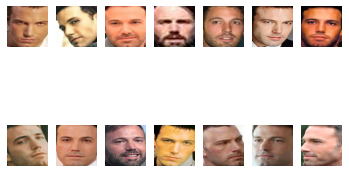

In [21]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
import tensorflow

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

with tensorflow.device('/cpu:0'):
    # specify folder to plot
    folder = '5-celebrity-faces-dataset/train/ben_afflek/'
    i = 1
    # enumerate files
    for filename in listdir(folder):
        # path
        path = folder + filename
        # get face
        face = extract_face(path)
        print(i, face.shape)
        # plot
        pyplot.subplot(2, 7, i)
        pyplot.axis('off')
        pyplot.imshow(face)
        i += 1
    pyplot.show()

In [22]:
!git init

Initialized empty Git repository in /home/duyanhle/Duy_Le_Ubuntu/Project/Python/cv/.git/


In [23]:
!echo "# Face-Recognition" >> README.md

In [24]:
!git add README.md
!git commit -m "first commit"
!git remote add origin https://github.com/duylebkHCM/Face-Recognition.git


[master (root-commit) 4600939] first commit
 1 file changed, 1 insertion(+)
 create mode 100644 README.md
Username for 'https://github.com': ^C


In [ ]:
!git push -u origin master

Username for 'https://github.com': 